<center> <h1>Using GraphWave </h1> </center>

&nbsp;

&nbsp;

The goal of the  following notebook is to show how the GraphWave algorithm can be used. 

GraphWave was implemented in Python 2.7 and requires to load the following Python packages:

+ __pygsp__ (Graph signal Processing package from EPFL, to compute spectral graph wavelets.)
+ __networkx__ (for handling network objects: in particular, visualization, etc.)
+ traditional libraries for data analytics: __seaborn__ for plotting, __pandas__ for dataframes


In [1]:
%matplotlib inline
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from graphwave.shapes import build_graph
from graphwave.graphwave import *


np.random.seed(123)


## I. Creating a graph

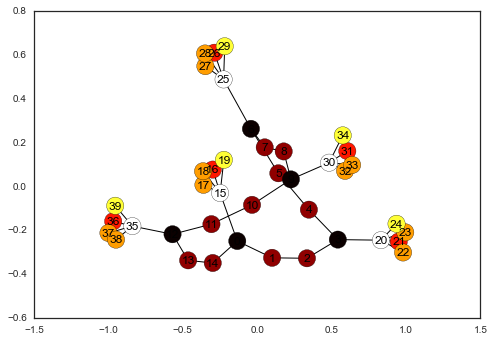

In [2]:
# 1- Start by defining our favorite regular structure

width_basis = 15
nbTrials = 20


################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

### 1. Choose the basis (cycle, torus or chain)
basis_type = "cycle" 

### 2. Add the shapes 
n_shapes = 5  ## numbers of shapes to add 
#shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
#shape=["star",6]
list_shapes = [["house"]] * n_shapes

### 3. Give a name to the graph
identifier = 'AA'  ## just a name to distinguish between different trials
name_graph = 'houses'+ identifier
sb.set_style('white')

### 4. Pass all these parameters to the Graph Structure
add_edges = 0
G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                       add_random_edges=add_edges, plot=True,
                                       savefig=False)

(Note: best visualization of the graphs are obtained using Gephi, or some other specialized graph visualization software)

## II. Running GraphWave


We propose here a simple demonstration of GraphWave using both the automatic version (part a) and the manual version. This shows how to use GraphWave in a parameter-free version, or giving the analyst the possibility to select an adequate scale value.

For each of these approaches, we compute the signature by calling GraphWave. We then compute its PCA projection to visualize the embeddings. Note that in this very simple examples, GraphWave recovers structura equivalence, as shown by the overlapping embeddings on the first principal components.

#### a. Multiscale GraphWave: Automatic selection of the range of scales

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 23 10:32:21 2018

@author: cdonnat
"""

import networkx as nx
import numpy as np
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from graphwave.shapes import build_graph
#from graphwave.graphwave import *
import time
np.random.seed(123)
import copy
import math

def compute_cheb_coeff(scale, order):
    coeffs = [(-scale)**k * 1.0 / math.factorial(k) for k in range(order + 1)]
    return coeffs

def compute_cheb_coeff_basis(scale, order):
    xx = np.array([np.cos((2*i-1)*1.0/(2*order) * math.pi) for i in range(1,order+1)])
    basis = [np.ones((1,order)),np.array(xx)]
    for k in range(order + 1-2):
        basis.append(2* np.multiply(xx, basis[-1]) - basis[-2])
    basis = np.vstack(basis)
    f = np.exp(-scale*(xx+1))
    products = np.einsum("j,ij->ij",f,basis)
    coeffs = 2.0/(order)*products.sum(1)
    coeffs[0] = coeffs[0]/2
    return list(coeffs)




def heat_diffusion_ind(graph, taus=[1, 10, 25, 50], diff_type='heat',order = 10, proc = 'approximate'):
    '''
    This method computes the heat diffusion waves for each of the nodes
    INPUT:
    -----------------------
    graph    :    Graph, can be of type networkx or pygsp
    taus     :    list of 4 scales for the wavelets. The higher the tau,
                  the better the spread
    order    :    order of the polynomial approximation

    OUTPUT:
    -----------------------
    heat     :     tensor of length  len(tau) x n_nodes x n_nodes
                   where heat[tau,:,u] is the wavelet for node u
                   at scale tau
    '''
    # Compute Laplacian

    a = nx.adjacency_matrix(graph)
    n_nodes, _ = a.shape
    thres = np.vectorize(lambda x : x if x > 1e-4*1.0/n_nodes else 0)
    lap = laplacian(a)
    n_filters = len(taus)
    if proc == 'exact':
        lamb, U = np.linalg.eigh(lap.todense())
        heat = {}
        for i in range(n_filters):
             heat[i] = U.dot(np.diagflat(np.exp(-taus[i]*lamb).flatten())).dot(U.T)
    else:
        heat = {i: sc.sparse.csc_matrix((n_nodes, n_nodes)) for i in range(n_filters) }
        #monome = {0: sc.sparse.eye(n_nodes)}
        #for k in range(1, order + 1):
        #     monome[k] = lap.dot(monome[k-1])
        monome = {0: sc.sparse.eye(n_nodes), 1: lap - sc.sparse.eye(n_nodes)}
        for k in range(2, order + 1):
             monome[k] = 2 * (lap - sc.sparse.eye(n_nodes)).dot(monome[k-1]) - monome[k - 2]
        for i in range(n_filters):
            coeffs = compute_cheb_coeff_basis(taus[i], order)
            #print(coeffs)
            heat[i] = sc.sum([  coeffs[k] * monome[k]  for k in range(0, order + 1)])
            index = heat[i].nonzero
            #temp = heat[i].A#
            temp = thres(heat[i].A)
            heat[i] = sc.sparse.csc_matrix(temp)
            #### trim the data:

             #for k in range(0, order + 1):
                 #heat[i] +=  coeffs[k] * monome[k]
    return heat, taus



import copy

def charac_function(time_points, temp):

    temp2=temp.T.tolil()
    d = temp2.data
    n_timepnts = len(time_pts)
    n_nodes = temp.shape[1]
    final_sig = np.zeros((2*n_timepnts, n_nodes))
    zeros_vec = np.array([1.0/n_nodes*(n_nodes - len(d[i])) for i in range(n_nodes)])

    for i in range(n_nodes):
         final_sig[::2,i] = zeros_vec[i] +\
                            1.0 / n_nodes * np.cos(np.einsum("i,j-> ij",
                                                             time_pts,
                                                             np.array(d[i]))).sum(1)

    for it_t, t in enumerate(time_points):
        final_sig[it_t * 2 + 1, :] = 1.0/n_nodes *(temp.sin().sum(0))

    return final_sig

def charac_function_multiscale(heat, time_points):
    final_sig = []
    for i in heat.keys():
        final_sig.append(charac_function(time_points, heat[i]))
    return np.vstack(final_sig).T


def laplacian(a):
        n_nodes, _ = a.shape
        posinv = np.vectorize(lambda x: 1.0/np.sqrt(x) if x>1e-10 else 1)
        d = sc.sparse.diags(np.array(posinv(a.sum(0))).reshape([-1,]),0)
        lap = sc.sparse.eye(n_nodes) - d.dot(a.dot(d))
        return lap

def graphwave2(graph, taus, time_pnts, type_graph="nx",
              verbose=False, **kwargs):
    ''' wrapper function for computing the structural signatures using GraphWave
    INPUT
    --------------------------------------------------------------------------------------
    graph      :   nx or pygsp Graph
    time_pt    :   time points at which to evaluate the characteristic function
    taus       :   list of scales that we are interested in. Alternatively,
                   'automatic' for the automatic version of GraphWave
    type_graph :   type of the graph used (either one of 'nx' or 'pygsp')
    verbose    :   the algorithm prints some of the hidden parameters
                   as it goes along
    OUTPUT
    --------------------------------------------------------------------------------------
    chi        :  embedding of the function in Euclidean space
    heat_print :  returns the actual embeddings of the nodes
    taus       :  returns the list of scales used.
    '''
    if taus == 'auto':
        a = nx.adjacency_matrix(G)
        lap = laplacian(a)
        try:
            l1 = np.sort(sc.sparse.linalg.eigsh(lap, 2,  which='SM',return_eigenvectors=False))[1]
        except:
            l1 = np.sort(sc.sparse.linalg.eigsh(lap, 5,  which='SM',return_eigenvectors=False))[1]
        smax = -np.log(0.8) * np.sqrt( 0.5 / l1)
        smin = -np.log(0.95) * np.sqrt( 0.5 / l1)
        taus = np.linspace(smin, smax, 2)
    heat_print, _ = heat_diffusion_ind(graph, list(taus), diff_type='heat', order=100, proc = 'approximate')
    chi = charac_function_multiscale(heat_print, time_pnts)

    return chi, heat_print, taus

time_alg=[]
if True:
    
    nbTrials = 20


    ################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
    ## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

    ### 1. Choose the basis (cycle, torus or chain)
    basis_type = "cycle"

    ### 2. Add the shapes
    n_shapes = 50 ## numbers of shapes to add
    width_basis = 5 * n_shapes
    #shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
    #shape=["star",6]
    #list_shapes = [["house"]] * n_shapes
    list_shapes = [["house"]] * n_shapes +[["star",8]]*n_shapes + [["fan",4]]*n_shapes
    np.random.shuffle(list_shapes)
    width_basis = 15 * n_shapes 


    ### 3. Give a name to the graph
    identifier = 'AA'  ## just a name to distinguish between different trials
    name_graph = 'houses'+ identifier


    ### 4. Pass all these parameters to the Graph Structure
    add_edges = 0
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    tic =time.time()
    time_pts = list(np.arange(0,50,2)) 
    chi, heat, taus = graphwave2(G, 'auto', time_pts)
    toc =time.time()
    print (toc-tic)
    time_alg+=[[G.number_of_nodes(),toc-tic]]
    #np.savetxt('log_scalable.txt', time_alg, fmt="%i, %f")
    Adj_graph=nx.adjacency_matrix(G).todense()
    Gi=igraph.Graph.Adjacency((Adj_graph > 0).tolist())
    ticX =time.time()
    test_RoleX=extract_rolx_roles(Gi,roles=len(np.unique(role_id)))
    tocX =time.time()
    print toc-tic, tocX-ticX






27.7428238392


NameError: name 'igraph' is not defined

In [6]:
G.number_of_nodes()

1700

In [ ]:
chi.shape


In [6]:
role_id

[-21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -21,
 0,
 0

In [7]:
list_shapes = [["house"]] * n_shapes +[["star",8]]*n_shapes 
if True:
    np.random.shuffle(list_shapes)
    width_basis = 50 * n_shapes 


    ### 3. Give a name to the graph
    identifier = 'AA'  ## just a name to distinguish between different trials
    name_graph = 'houses'+ identifier


    ### 4. Pass all these parameters to the Graph Structure
    add_edges = 0
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    time_pts = np.linspace(0,100,101)
    chi, heat, taus = graphwave2(G, 'auto', time_pts)

In [ ]:
check_perf(chi, role_id)

In [ ]:
help(AffinityPropagation)

In [7]:
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, f1_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN, AffinityPropagation
def check_perf(chi, role_id, plot=True):
    nb_clust = len(np.unique(role_id))
    pca = PCA(n_components=5)
    trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))
    #trans_data=chi
    km = AffinityPropagation()
    #km= AgglomerativeClustering(n_clusters=nb_clust)
    km.fit(trans_data)
    labels_pred=km.labels_
    print "number cluster found", len(np.unique(labels_pred))

    ######## Params for plotting
    cmapx=plt.get_cmap('rainbow')
    x=np.linspace(0,1,len(role_id))
    col=[cmapx(xx) for xx in x ]
    markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}
    if plot:
        plt.figure()
        for c in np.unique(role_id):
            indc = [i for i,x in enumerate(role_id) if x==c]
            plt.scatter(trans_data[indc,0], trans_data[indc,1],
                        c=np.array(col)[list(np.array(labels_pred)[indc])],
                        marker=markers[c%len(markers)], s=300)

        labels = role_id
        for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
                    plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')



    return (homogeneity_score(role_id,labels_pred), completeness_score(role_id,labels_pred),
           f1_score(role_id,labels_pred, average='weighted'), silhouette_score(chi,role_id),len(np.unique(labels_pred)))
    



In [8]:
mapping= {u: i for i,u in enumerate(np.unique(role_id))}
GT_labels = [mapping[l] for l in role_id]

In [9]:
help(AffinityPropagation)

Help on class AffinityPropagation in module sklearn.cluster.affinity_propagation_:

class AffinityPropagation(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin)
 |  Perform Affinity Propagation Clustering of data.
 |  
 |  Read more in the :ref:`User Guide <affinity_propagation>`.
 |  
 |  Parameters
 |  ----------
 |  damping : float, optional, default: 0.5
 |      Damping factor (between 0.5 and 1) is the extent to
 |      which the current value is maintained relative to
 |      incoming values (weighted 1 - damping). This in order
 |      to avoid numerical oscillations when updating these
 |      values (messages).
 |  
 |  max_iter : int, optional, default: 200
 |      Maximum number of iterations.
 |  
 |  convergence_iter : int, optional, default: 15
 |      Number of iterations with no change in the number
 |      of estimated clusters that stops the convergence.
 |  
 |  copy : boolean, optional, default: True
 |      Make a copy of input data.
 |  
 |  preference : array

[]

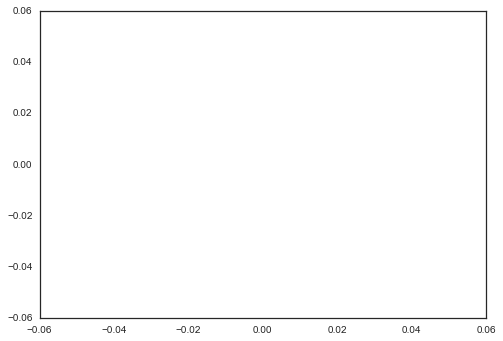

In [10]:
plt.figure()
plt.plot()

In [11]:
import time 
import igraph
from graphwave.roleX import *
time_alg={}
time_algRolX={}
time_pts = list(np.arange(0, 100,4))
n_shapes = 40
n_edges = 0

for add_edges_pct in [0, 0.1,0.5,1.0,3.0,5.0,7.5,10.0,12.5]:
    time_alg[add_edges_pct] = []
    time_algRolX[add_edges_pct] = []
    for b in range(10):
        ### 1. Choose the basis (cycle, torus or chain)
        list_shapes = [["house"]] * n_shapes +[["star",10]]*n_shapes + [["fan",6]]*n_shapes
        width_basis = 15 * n_shapes 

        ### 3. Give a name to the graph
        identifier = 'AA'  ## just a name to distinguish between different trials
        name_graph = 'houses'+ identifier

        ### 4. Pass all these parameters to the Graph Structure
        add_edges = int(add_edges_pct*1.0 /100 * n_edges)
        print(add_edges)
        G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                               add_random_edges=add_edges, plot=False,
                                               savefig=False)
        mapping= {u: i for i,u in enumerate(np.unique(role_id))}
        GT_labels = [mapping[l] for l in role_id]
        if add_edges_pct == 0:
            n_edges = G.number_of_edges()
        tic =time.time()
        chi, _ ,taus =graphwave2(G, 'auto', time_pts, verbose=False)
        toc =time.time() 
        temp = check_perf(chi, GT_labels, plot=False)
        time_alg[add_edges_pct]+=[[G.number_of_nodes(),toc-tic, taus[0], taus[1], temp ]]
        #np.savetxt("log_scalable.txt", time_alg, fmt="%i, %f, %f, %f")

        Adj_graph=nx.adjacency_matrix(G).todense()
        Gi=igraph.Graph.Adjacency((Adj_graph > 0).tolist())
        tic =time.time()
        test_RoleX=extract_rolx_roles(Gi,roles=len(np.unique(role_id)))
        chiX=test_RoleX[0]
        tempX = check_perf(chiX, GT_labels, plot=False)
        toc =time.time() 
        time_algRolX[add_edges_pct]+=[[G.number_of_nodes(),toc-tic, tempX]]
        



0
number cluster found 1043
Creating Vertex Features matrix


/Users/cdonnat/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


number cluster found 680
0
number cluster found 1353
Creating Vertex Features matrix
number cluster found 1000
0
number cluster found 1283
Creating Vertex Features matrix
number cluster found 680
0
number cluster found 1326
Creating Vertex Features matrix
number cluster found 720
0
number cluster found 1201
Creating Vertex Features matrix
number cluster found 958
0
number cluster found 1115
Creating Vertex Features matrix
number cluster found 960
0
number cluster found 1081
Creating Vertex Features matrix
number cluster found 1000
0
number cluster found 1354
Creating Vertex Features matrix
number cluster found 960
0
number cluster found 1402
Creating Vertex Features matrix
number cluster found 760
0
number cluster found 1238
Creating Vertex Features matrix
number cluster found 841
1
967 538
number cluster found 445
Creating Vertex Features matrix
number cluster found 1361
1
1271 263
number cluster found 852
Creating Vertex Features matrix
number cluster found 1320
1
1087 1
number clust

KeyboardInterrupt: 

In [12]:
time_alg[add_edges_pct]

[[1520,
  117.86457991600037,
  0.53735014643019807,
  2.3376587798725499,
  (0.89433783749393281,
   0.44372540085835899,
   0.26363705571253926,
   0.23568419520667694,
   389)]]

In [11]:
time_algRolX[add_edges_pct]

[[570,
  338.25372409820557,
  (0.86888413516245044,
   0.50628061528763668,
   0.098622144985104257,
   0.19232590488018395,
   123)],
 [570,
  319.0634868144989,
  (0.84198363103763574,
   0.48935081914873907,
   0.039515856950067471,
   0.24309335344540223,
   124)],
 [570,
  318.9828691482544,
  (0.86462720303461371,
   0.51585952356399345,
   0.038891669976613447,
   0.24045677166128956,
   91)],
 [570,
  289.68097710609436,
  (0.89580639373213411,
   0.50576050155430008,
   0.0032388663967611343,
   0.2875823055745001,
   131)]]

In [2]:
time_algRolX={}
[[570,
  338.25372409820557,
  (0.86888413516245044,
   0.50628061528763668,
   0.098622144985104257,
   0.19232590488018395,
   123)],
 [570,
  319.0634868144989,
  (0.84198363103763574,
   0.48935081914873907,
   0.039515856950067471,
   0.24309335344540223,
   124)],
 [570,
  318.9828691482544,
  (0.86462720303461371,
   0.51585952356399345,
   0.038891669976613447,
   0.24045677166128956,
   91)],
 [570,
  289.68097710609436,
  (0.89580639373213411,
   0.50576050155430008,
   0.0032388663967611343,
   0.2875823055745001,
   131)]]
time_algRolX[10.0]=[[570,
  315.98472595214844,
  (0.8410563123559408,
   0.51114485322879266,
   0.0056107249255213506,
   0.20198134246204327,
   61)],
 [570,
  373.7920160293579,
  (0.78407351392201019,
   0.48347052303232912,
   0.085139318885448914,
   0.19875808391859509,
   96)],
 [570,
  274.05317401885986,
  (0.79733410997102971,
   0.47914436429087698,
   0.013110733823806828,
   0.042955806747209155,
   66)],
 [570,
  315.4001169204712,
  (0.81810252302431574,
   0.53190999311081388,
   0.0018148820326678767,
   0.15309475071300901,
   40)]]

NameError: name 'time_algRolX' is not defined

In [14]:
time_alg[10.0]=[[570,
  2.314671039581299,
  0.45006377439375989,
  1.9579329059526345,
  (0.66784842050319382,
   0.3801431744991704,
   0.007480633477603112,
   -0.23869439411579199,
   62)],
 [570,
  1.8261489868164062,
  0.43607438850538899,
  1.897074244306725,
  (0.65503605149670363,
   0.3645498639121022,
   0.1042054055784033,
   -0.18869204587079819,
   79)],
 [570,
  1.9899990558624268,
  0.36081204371179842,
  1.569657042935614,
  (0.67277539138259346,
   0.38991105629952605,
   0.10285058440493756,
   -0.24246786414989946,
   87)],
 [570,
  1.5990369319915771,
  0.40364915704538401,
  1.7560132852366661,
  (0.68179476056734922,
   0.4261561012345384,
   0.0095712021189076398,
   -0.20653531597387165,
   48)],
 [570,
  1.8854291439056396,
  0.39617597793117798,
  1.7235023742674564,
  (0.69030805456588229,
   0.42478133388682632,
   0.071255339968741838,
   -0.21610338458693254,
   41)]]

In [13]:
add_edges_pct

7.5

In [31]:
r=[0, 0.1,0.5,1.0,3.0,5.0,7.5]

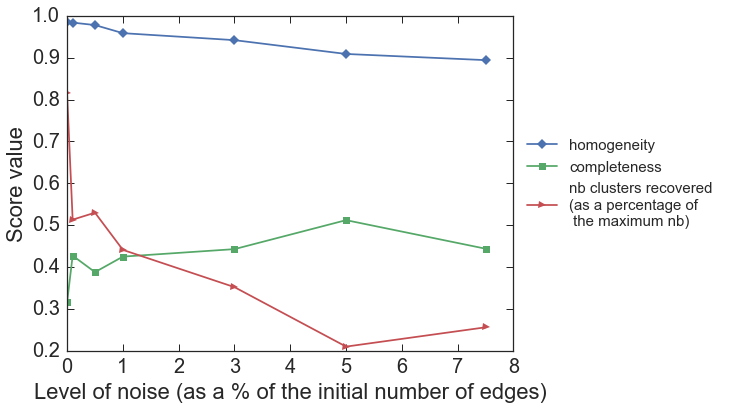

In [38]:
sb.set(font_scale = 2)
sb.set_style('white')
sb.set_context(font_scale=2.0)
sb.set_style("ticks")
sb.set_style({"xtick.direction":"in","ytick.direction":"in"})
fig, ax =plt.subplots(figsize=(8,6))
ax.tick_params(axis='both', direction='in',length=7)

plt.plot([0, 0.1,0.5,1.0,3.0,5.0,7.5],[np.mean([time_alg[rr][i][4][0] for i in range(len(time_alg[rr]))]) for rr in r], marker='D', label='homogeneity')
plt.plot([0, 0.1,0.5,1.0,3.0,5.0,7.5],[np.mean([time_alg[rr][i][4][1]for i in range(len(time_alg[rr]))]) for rr in r], marker='s', label='completeness')
plt.plot([0, 0.1,0.5,1.0,3.0,5.0,7.5],[np.mean([time_alg[rr][i][4][4]*1.0/G.number_of_nodes()for i in range(len(time_alg[rr]))]) for rr in r], marker='>', label='nb clusters recovered \n(as a percentage of \n the maximum nb)')
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5),fontsize=15)
plt.xlabel("Level of noise (as a % of the initial number of edges)")
plt.ylabel("Score value")
plt.savefig("/Users/cdonnat/claire-david-marinka-structsim/KDD/FIG/accuracy_noise2.pdf", bbox_inches='tight')

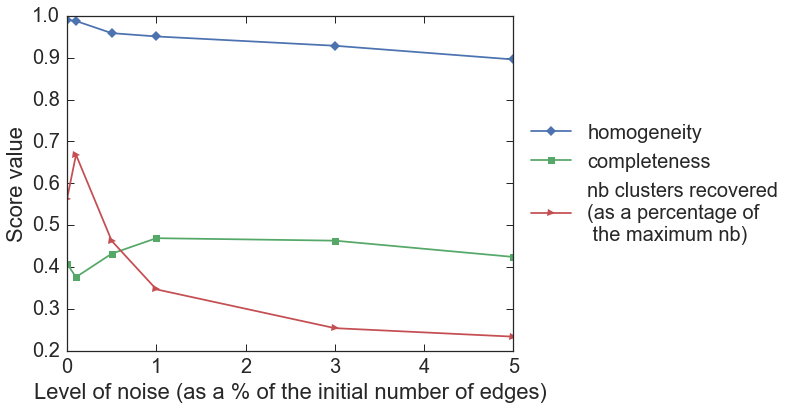

In [28]:
sb.set(font_scale = 2)
sb.set_style('white')
sb.set_context(font_scale=2.0)
sb.set_style("ticks")
sb.set_style({"xtick.direction":"in","ytick.direction":"in"})
fig, ax =plt.subplots(figsize=(8,6))
ax.tick_params(axis='both', direction='in',length=7)
r=[0, 0.1,0.5,1.0,3.0,5.0]
plt.plot(r,[np.mean([time_algRolX[rr][i][2][0] for i in range(len(time_algRolX[rr]))]) for rr in r], marker='D', label='homogeneity')
plt.plot(r,[np.mean([time_algRolX[rr][i][2][1]for i in range(len(time_algRolX[rr]))]) for rr in r], marker='s', label='completeness')
plt.plot(r,[np.mean([time_algRolX[rr][i][2][4]*1.0/G.number_of_nodes()for i in range(len(time_algRolX[rr]))]) for rr in r], marker='>', label='nb clusters recovered \n(as a percentage of \n the maximum nb)')
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
plt.xlabel("Level of noise (as a % of the initial number of edges)")
plt.ylabel("Score value")
plt.savefig("/Users/cdonnat/Downloads/accuracy_noise2RolX.pdf", bbox_inches='tight')

In [27]:
time_algRolX

{0: [[1520,
   17.365672826766968,
   (0.99779590773336801,
    0.51175999003209283,
    0.0012836970474967911,
    0.8210261370416243,
    680)],
  [1520,
   15.134582042694092,
   (1.0000000000000002,
    0.37550490718936463,
    0.0013130539446328919,
    0.8210261370416243,
    1000)],
  [1520,
   16.38052201271057,
   (0.95952819479131346,
    0.37737636340799247,
    0.0013130539446328919,
    0.8210261370416243,
    680)],
  [1520,
   15.583432912826538,
   (1.0, 0.43677097954818672, 0.0013130539446328919, 0.8210261370416243, 720)],
  [1520,
   14.828736066818237,
   (1.0000000000000004,
    0.39221505743872653,
    0.0013130539446328919,
    0.8210261370416243,
    958)],
  [1520,
   14.838283061981201,
   (1.0000000000000004,
    0.38313461990371056,
    0.0013130539446328919,
    0.8210261370416243,
    960)],
  [1520,
   16.975123167037964,
   (1.0000000000000004,
    0.38508664339193999,
    0.0013130539446328919,
    0.8210261370416243,
    1000)],
  [1520,
   14.809491872

In [ ]:
help(plt.scatter)

In [ ]:
help(matplotlib.markers)

In [ ]:
chi, heat_print, taus=graphwave(G, taus='automatic', verbose=False)

In [ ]:

import copy
import math
def compute_cheb_coeff(scale, order):
    coeffs = [(-scale)**k * 1.0 / math.factorial(k) for k in range(order + 1)]
    return coeffs

def compute_cheb_coeff_basis(scale, order):
    xx = np.array([np.cos((2*i-1)*1.0/(2*order) * math.pi) for i in range(1,order+1)])
    basis = [np.ones((1,order)),np.array(xx)]
    for k in range(order + 1-2):
        basis.append(2* np.multiply(xx, basis[-1]) - basis[-2])
    basis = np.vstack(basis)
    f = np.exp(-scale*(xx+1))
    products = np.einsum("j,ij->ij",f,basis)
    coeffs = 2.0/(order)*products.sum(1)
    coeffs[0] = coeffs[0]/2
    return list(coeffs)




def heat_diffusion_ind(graph, taus=[1, 10, 25, 50], diff_type='heat',order = 10, proc = 'approximate'):
    '''
    This method computes the heat diffusion waves for each of the nodes
    INPUT:
    -----------------------
    graph    :    Graph, can be of type networkx or pygsp
    taus     :    list of 4 scales for the wavelets. The higher the tau,
                  the better the spread
    order    :    order of the polynomial approximation

    OUTPUT:
    -----------------------
    heat     :     tensor of length  len(tau) x n_nodes x n_nodes
                   where heat[tau,:,u] is the wavelet for node u
                   at scale tau
    '''
    # Compute Laplacian 
    
    a = nx.adjacency_matrix(graph)
    n_nodes, _ = a.shape
    thres = np.vectorize(lambda x : x if x > 0.001*1.0/n_nodes else 0)
    lap = laplacian(a)
    n_filters = len(taus)
    if proc == 'exact':
        lamb, U = np.linalg.eigh(lap.todense())
        heat = {}
        for i in range(n_filters):
             heat[i] = U.dot(np.diagflat(np.exp(-taus[i]*lamb).flatten())).dot(U.T)
    else:
        heat = {i: sc.sparse.csc_matrix((n_nodes, n_nodes)) for i in range(n_filters) }
        #monome = {0: sc.sparse.eye(n_nodes)}
        #for k in range(1, order + 1):
        #     monome[k] = lap.dot(monome[k-1])
        monome = {0: sc.sparse.eye(n_nodes), 1: lap - sc.sparse.eye(n_nodes)}
        for k in range(2, order + 1):
             monome[k] = 2 * (lap - sc.sparse.eye(n_nodes)).dot(monome[k-1]) - monome[k - 2]
        for i in range(n_filters):
            coeffs = compute_cheb_coeff_basis(taus[i], order)
            #print(coeffs)
            heat[i] = sc.sum([  coeffs[k] * monome[k]  for k in range(0, order + 1)])
            index = heat[i].nonzero
            temp = thres(heat[i].A)
            heat[i] = sc.sparse.csc_matrix(temp)
            #### trim the data:
            
             #for k in range(0, order + 1):
                 #heat[i] +=  coeffs[k] * monome[k] 
    return heat, taus




In [ ]:
test, _ =heat_diffusion_ind(G)


In [ ]:
test

In [ ]:
def charac_function(time_points, temp):
#time_points= np.linspace(0,100,101)
#if True
    sig = []
    for t in time_points:
        complexify = np.vectorize( lambda x: np.exp(-np.complex(0,t*x)))
        sig.append(complexify(temp.A).mean(0))
    sig = np.vstack(sig)
    final_sig = np.zeros((2*sig.shape[0],sig.shape[1]))
    final_sig[::2,:] = np.real(sig)
    final_sig[1::2,:]= np.imag(sig)
    return final_sig

def charac_function_multiscale(heat, time_points):
    final_sig = []
    for i in heat.keys():
        final_sig.append(charac_function(time_points, heat[i]))
    return np.vstack(final_sig).T
        

In [ ]:
def laplacian(a):
        n_nodes, _ = a.shape
        posinv = np.vectorize(lambda x: 1.0/np.sqrt(x) if x>1e-10 else 1)
        d = sc.sparse.diags(np.array(posinv(a.sum(0))).reshape([-1,]),0)
        lap = sc.sparse.eye(n_nodes) - d.dot(a.dot(d))
        return lap
    
def graphwave2(graph, taus, time_pnts, type_graph="nx",
              verbose=False, **kwargs):
    ''' wrapper function for computing the structural signatures using GraphWave
    INPUT
    --------------------------------------------------------------------------------------
    graph      :   nx or pygsp Graph
    time_pt    :   time points at which to evaluate the characteristic function
    taus       :   list of scales that we are interested in. Alternatively,
                   'automatic' for the automatic version of GraphWave
    type_graph :   type of the graph used (either one of 'nx' or 'pygsp')
    verbose    :   the algorithm prints some of the hidden parameters
                   as it goes along
    OUTPUT
    --------------------------------------------------------------------------------------
    chi        :  embedding of the function in Euclidean space
    heat_print :  returns the actual embeddings of the nodes
    taus       :  returns the list of scales used.
    '''
    if taus == 'auto':
        a = nx.adjacency_matrix(G)
        lap = laplacian(a)
        l1 = sc.sparse.linalg.eigsh(lap, 2,  which='SM',return_eigenvectors=False)[0]
        smax = -np.log(0.75) * np.sqrt( 0.5 / l1)
        smin = -np.log(0.99) * np.sqrt( 0.5 / l1)
        taus = np.linspace(smin, smax, 4)
    heat_print, _ = heat_diffusion_ind(graph, list(taus), diff_type='heat', order=50, proc = 'approximate')
    chi = charac_function_multiscale(heat_print, time_pnts)

    return chi



In [ ]:
chi = graphwave2(G, 'auto')

In [ ]:
chi.shape

We now visualize the resulting embeddings by computing their PCA projections. We also run KMeans to assess how well the signatures that we have here generated enable the recovery of structural roles.

In [ ]:
nb_clust = len(np.unique(role_id))
pca = PCA(n_components=5)
trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))
km = KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_

######## Params for plotting
cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,nb_clust+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}

for c in np.unique(role_id):
    indc = [i for i,x in enumerate(role_id) if x==c]
    plt.scatter(trans_data[indc,0], trans_data[indc,1],
                c=np.array(col)[list(np.array(labels_pred)[indc])],
                marker=markers[c%len(markers)], s=300)

labels = role_id
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

In [ ]:
labels_pred

#### Uniscale GraphWave: Hand-selected value for tau

In [ ]:
heat

In [ ]:
### Select a scale of interest (here we select a particular range of scale. See associated paper for 
### guidelines on how to select the appropriate scale.)


time_pts = list(np.arange(0,50,0.5))
chi =graphwave2(G, taus = [1], time_pts=time_pts, verbose=False)
print(chi.shape, len(time_pts))

Note that in the EPFL implementation, by construction, the wavelet scales are all divided by the maximum eigenvalue $\lambda_N$.

In [ ]:
list(np.arange(0, 10,0.5)) +list(np.arange(10,100,10))

In [ ]:

time_pts = list(np.arange(0, 10,0.5)) +list(np.arange(10,110,10))
chi =graphwave2(G, 'auto', time_pts)
nb_clust=len(np.unique(role_id))
pca=PCA(n_components=5)
trans_data=pca.fit_transform(StandardScaler().fit_transform(chi))
km=KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_


cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,np.max(labels_pred)+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}


for c in np.unique(role_id):
        indc=[i for i,x in enumerate(role_id) if x==c]
        _ = plt.scatter(trans_data[indc,0], trans_data[indc,1],c=np.array(col)[list(np.array(labels_pred)[indc])] ,marker=markers[c%len(markers)],s=500)

labels = role_id
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            _ = plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

### Scalability experiment

In [ ]:
np.arange(10,5000,25)

In [ ]:
import time 
time_alg=[]
time_pts = list(np.arange(0,10,0.5)) + list(np.arange(10,110,10)) 
for n_shapes in np.arange(10,5000,25):
    ### 1. Choose the basis (cycle, torus or chain)
    list_shapes = [["house"]] * n_shapes
    width_basis = 4 * n_shapes 

    ### 3. Give a name to the graph
    identifier = 'AA'  ## just a name to distinguish between different trials
    name_graph = 'houses'+ identifier
    sb.set_style('white')

    ### 4. Pass all these parameters to the Graph Structure
    add_edges = 0
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    tic =time.time()
    chi =graphwave2(G, 'auto', time_pts, verbose=False)
    toc =time.time() 
    time_alg.append(toc-tic)
    print(G.number_of_nodes(),time_alg[-1], chi.shape)
    

In [ ]:
chi.shape

In [ ]:
len(time_pts)*2*3

## III. Visualizing the Characteristic functions

We now propose to show how to visualize characteristic functions.


In [ ]:
mapping = {u: i for i,u in enumerate(np.unique(role_id))}
cmap=plt.get_cmap('gnuplot')
role_id_plot=[cmap(x) for x in np.linspace(0,1,len(np.unique(role_id)))]
plt.figure()
ind_x=range(chi[0].shape[0])[0::2]
ind_y=range(chi[0].shape[0])[1::2]
for i in np.random.choice(range(G.number_of_nodes()),10,replace=False):
    _ = plt.plot(chi[i,ind_x],chi[i,ind_y],label=str(i),color=role_id_plot[mapping[role_id[i]]])

_ = plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
